<a href="https://colab.research.google.com/github/konerjonlar/ml-bootcamp-medical-cost/blob/main/notebooks/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Required Libraries

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Perform An Exploratory Data Analysis

In [20]:
# Load dataset
df = pd.read_csv('insurance.csv')

# Display general information about the dataset
print("Display Columns:", df.columns,
      "\nData Size:", df.shape,
      "\nData Types:", df.dtypes,
      "\nFirst 10 Rows:", df.head(10),
      "\nLast 4 Rows:", df.tail(4),
      "\nTotal Null Values:", df.isnull().sum().sum(),
      "\nGeneral Statistics:", df.describe(), sep="\n")

# Check Categorical Variables
categorical_vars = ["children", "smoker", "region"]
for var in categorical_vars:
    print(f"\n{var.capitalize()} Value Counts:\n", df[var].value_counts())


Display Columns:
Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

Data Size:
(1338, 7)

Data Types:
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

First 10 Rows:
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
5   31  female  25.740         0     no  southeast   3756.62160
6   46  female  33.440         1     no  southeast   8240.58960
7   37  female  27.740         3     no  northwest   7281.50560
8   37    male  29.830         2     no  northeast   6406.41070
9   60  female  25.840         0     no  northwest

In [21]:
# Set the threshold values for categorical columns
cat_threshold = 10
car_threshold = 20

# Identify Categorical Columns
categorical_columns = [col for col in df.columns if df[col].dtypes == "O"]

# Identify Numeric Columns that Behave Like Categorical
num_but_categorical = [col for col in df.columns if df[col].nunique() < cat_threshold and df[col].dtypes != "O"]

# Identify Categorical Columns that Behave Like Numeric
categorical_but_cardinal = [col for col in df.columns if df[col].nunique() > car_threshold and df[col].dtypes == "O"]

# Combine the lists of categorical columns
categorical_columns = categorical_columns + num_but_categorical

# Remove columns that behave like cardinal categorical columns
categorical_columns = [col for col in categorical_columns if col not in categorical_but_cardinal]

# Identify Numeric Columns
numeric_columns = [col for col in df.columns if df[col].dtypes != "O"]

# Remove columns that behave like numeric but categorical
numeric_columns = [col for col in numeric_columns if col not in num_but_categorical]

# Print Summary Information
print(f"Observations: {df.shape[0]}")
print(f"Variables: {df.shape[1]}")
print(f"Categorical Columns: {len(categorical_columns)}")
print(f"Numeric Columns: {len(numeric_columns)}")
print(f"Categorical Variables that Behave Like Numeric: {len(num_but_categorical)}")
print(f"Numeric Variables that Behave Like Categorical: {len(categorical_but_cardinal)}")


Observations: 1338
Variables: 7
Categorical Columns: 4
Numeric Columns: 3
Categorical Variables that Behave Like Numeric: 1
Numeric Variables that Behave Like Categorical: 0


# Removing Outlier Values


In [22]:
# Determine Outlier Columns
outlier_columns = ['age', 'bmi', 'charges']

# Define Outlier Criteria and IQR Factor
outlier_factor = 1.5

for col in outlier_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - outlier_factor * IQR
    upper_bound = Q3 + outlier_factor * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

Examine the distribution of Bmi (Body Mass Index)


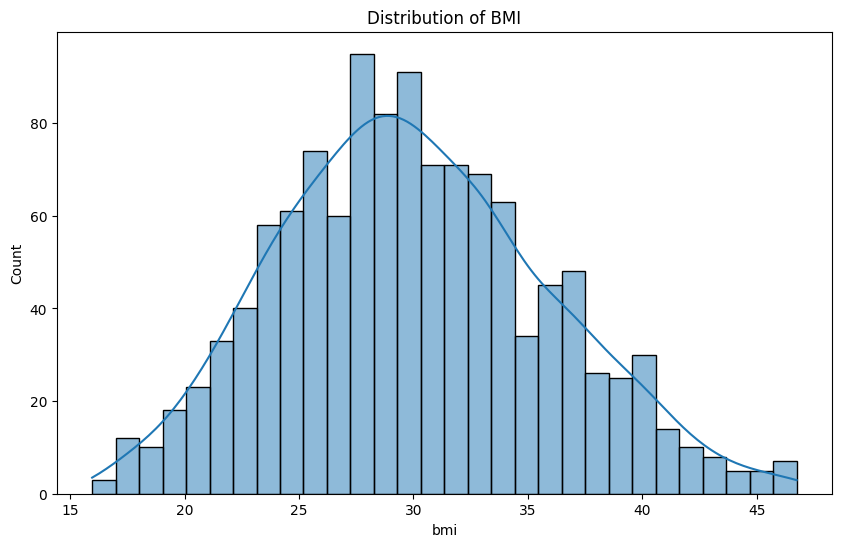

In [23]:
# Bmi Dağılımı
plt.figure(figsize=(10, 6))
sns.histplot(df['bmi'], bins=30, kde=True)
plt.title('Distribution of BMI')
plt.show()
# Diğer analizler aynı şekilde devam eder...


Examine the relationship between “smoker” and “charges”

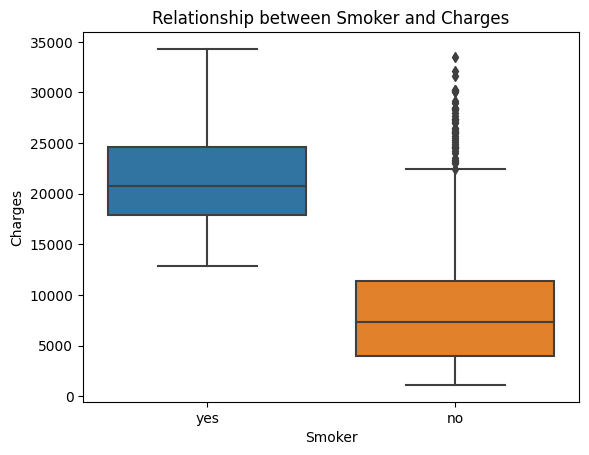

In [24]:
# Examine the relationship between "smoker" and "charges"
sns.boxplot(x='smoker', y='charges', data=df)
plt.title('Relationship between Smoker and Charges')
plt.xlabel('Smoker')
plt.ylabel('Charges')
plt.show()


Examine the relationship between “smoker” and “region”.


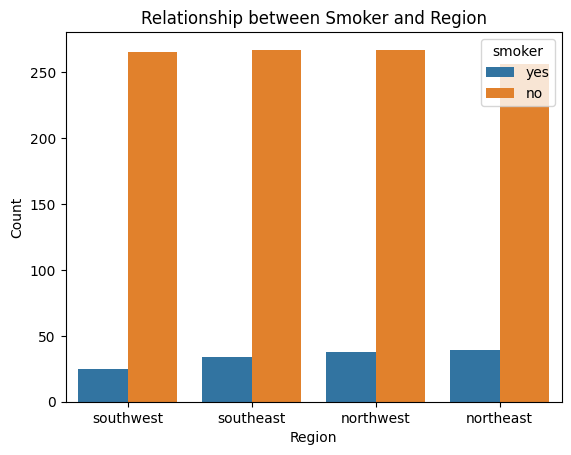

In [25]:
# Examine the relationship between "smoker" and "region"
sns.countplot(x='region', hue='smoker', data=df)
plt.title('Relationship between Smoker and Region')
plt.xlabel('Region')
plt.ylabel('Count')
plt.show()


Examine the relationship between “bmi” and “sex”.


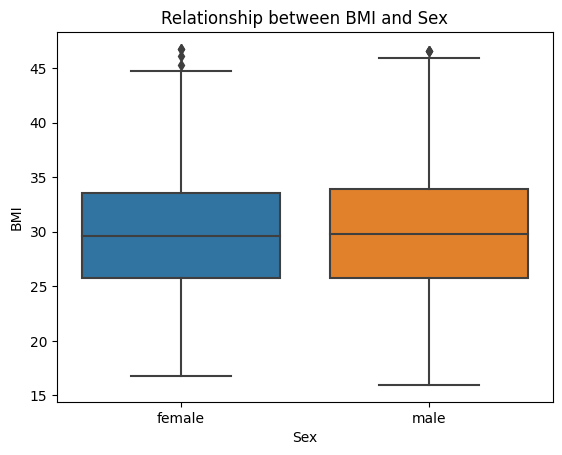

In [26]:
# Examine the relationship between "bmi" and "sex"
sns.boxplot(x='sex', y='bmi', data=df)
plt.title('Relationship between BMI and Sex')
plt.xlabel('Sex')
plt.ylabel('BMI')
plt.show()


Find the "region" with the most "children".


In [27]:
# Find the "region" with the most "children"
most_children_region = df.groupby('region')['children'].sum().idxmax()
print('Region with Most Children:', most_children_region)


Region with Most Children: northwest


Examine the relationship between “age” and “bmi”.


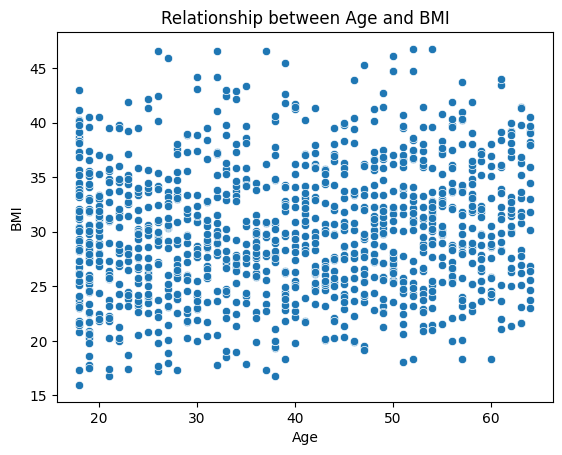

In [28]:
# Examine the relationship between "age" and "bmi"
sns.scatterplot(x='age', y='bmi', data=df)
plt.title('Relationship between Age and BMI')
plt.xlabel('Age')
plt.ylabel('BMI')
plt.show()


Examine the relationship between “bmi” and “children”.


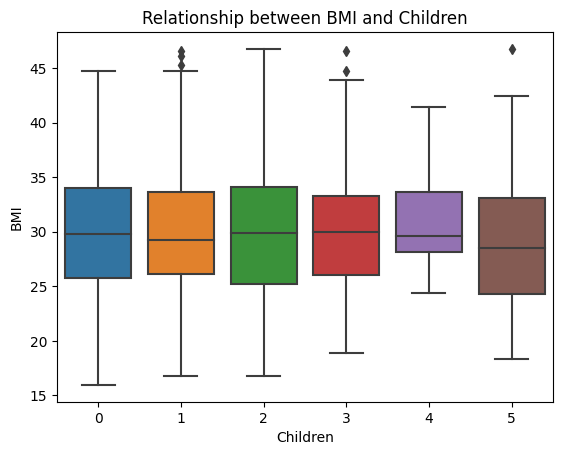

In [29]:
# Examine the relationship between "bmi" and "children"
sns.boxplot(x='children', y='bmi', data=df)
plt.title('Relationship between BMI and Children')
plt.xlabel('Children')
plt.ylabel('BMI')
plt.show()


Is there an outlier in the "bmi" variable? Please review.


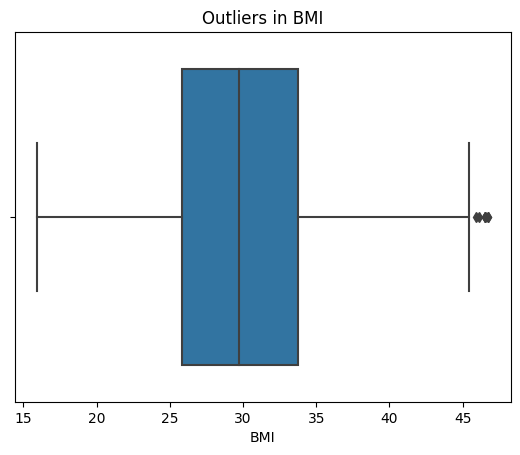

In [30]:
# Check for outliers in the "bmi" variable
sns.boxplot(x=df['bmi'])
plt.title('Outliers in BMI')
plt.xlabel('BMI')
plt.show()


Examine the relationship between “bmi” and “charges”.


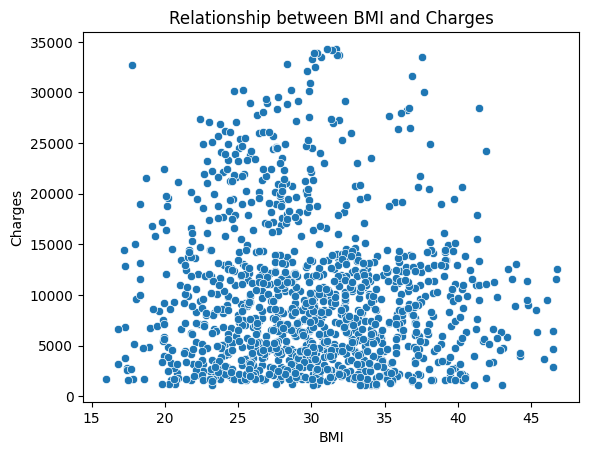

In [31]:
# Examine the relationship between "bmi" and "charges"
sns.scatterplot(x='bmi', y='charges', data=df)
plt.title('Relationship between BMI and Charges')
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.show()


Examine the relationship between “region”, “smoker” and “bmi” using bar

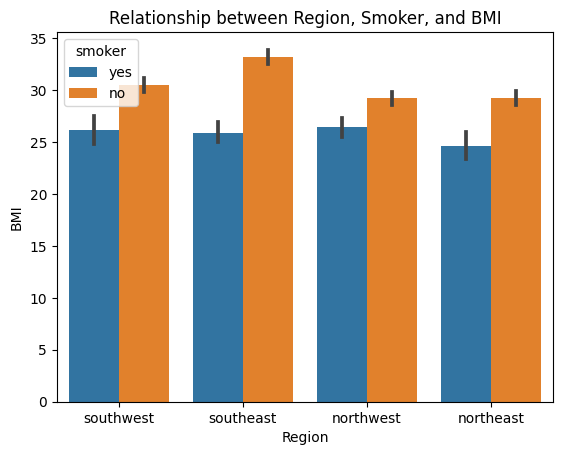

In [32]:
# Examine the relationship between "region", "smoker", and "bmi" using bar plot
sns.barplot(x='region', y='bmi', hue='smoker', data=df)
plt.title('Relationship between Region, Smoker, and BMI')
plt.xlabel('Region')
plt.ylabel('BMI')
plt.show()


# Data Preprocessing

In [33]:
# Kategorik özellikleri dönüştürmek için Label Encoding ve One-Hot Encoding
label_encoder = LabelEncoder()
df['sex'] = label_encoder.fit_transform(df['sex'])
df['smoker'] = label_encoder.fit_transform(df['smoker'])
onehot_encoder = OneHotEncoder(drop='first', sparse=False)
encoded_region = onehot_encoder.fit_transform(df[['region']])
encoded_region_df = pd.DataFrame(encoded_region, columns=onehot_encoder.get_feature_names_out(['region']))
df_encoded = pd.concat([df, encoded_region_df], axis=1)
df_encoded.drop(['region'], axis=1, inplace=True)

# Bağımsız değişkenler (X) ve bağımlı değişken (y) ayırma
X = df_encoded.drop(['charges'], axis=1)
y = df_encoded['charges']

# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Veriyi ölçeklendirme (Standard Scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# Model Selection

In [34]:
# Farklı regresyon modellerini seçme
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest Regressor': RandomForestRegressor(),
    'Support Vector Regressor': SVR()
}

# Modelleri eğitme ve çapraz doğrulama ile performansı değerlendirme
results = {}
for model_name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    results[model_name] = rmse_scores.mean()

# Modelleri performansa göre sıralama
sorted_results = sorted(results.items(), key=lambda x: x[1])
for model_name, rmse_score in sorted_results:
    print(f'{model_name}: RMSE = {rmse_score:.2f}')


ValueError: ignored

# Hyper-parameter Optimization

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Lineer Regresyon modelini oluşturma
model = LinearRegression()

# Hiperparametreler ve değer aralıkları
param_grid = {
    # Lineer Regresyon modeli için herhangi bir hiperparametre bulunmuyor
}

# Grid Search ile hiperparametre optimizasyonu
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train, y_train)

# En iyi modeli seçme
best_model = grid_search.best_estimator_

# Test verisi üzerinde tahmin yapma
y_pred = best_model.predict(X_test)

# RMSE hesaplama
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test RMSE:", rmse)


# Model Evaluation

In [ ]:
# En iyi modeli seçme
best_model = grid_search.best_estimator_

# Test verileri üzerinde tahmin yapma
y_pred = best_model.predict(X_test)

# Hata metriklerini hesaplama
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Sonuçları yazdırma
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')


In [ ]:
# Model seçimi ve eğitimi
best_model = RandomForestRegressor()  # Örnek olarak Random Forest Regressor seçildi
best_model.fit(X_train, y_train)



In [ ]:
# Grid Search ile hiperparametre optimizasyonu
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(best_model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train, y_train)

# En iyi model ve sonuçları
best_model = grid_search.best_estimator_
best_rmse = np.sqrt(-grid_search.best_score_)

print("Best Parameters:", grid_search.best_params_)
print("Best RMSE:", best_rmse)
